In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels
from tqdm import tqdm_notebook

In [3]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)
        
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [4]:
BATCH_SIZE = 64
sz = 256
NUM_WORKERS = 16

## Dataset

In [5]:
df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
data_folder = './data/patches/'
paths = [data_folder + str(patch) + '_2.png' for patch in df.patchId]
df['path'] = paths
df = df.set_index('path',drop=False)
df = df.drop(columns=['patchId','fileName','center','node','centerX','centerY',
                      'isTumor','tumorPercentage','tissuePercentage','meanHue',
                     'patient','meanSaturation','meanValue','tumorLabel'])
df.describe()

path
count                                   134710
unique                                  134421
top     ./data/patches/73001676800019712_2.png
freq                                         2

In [6]:
import random

def randomizeStaining(img, Io=240, alpha=1, beta=0.15, maxC1=None, maxC2=None):
    ''' Randomize staining appearence of H&E stained images
    
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    ε = 0.10
    θ = 4.0
    maxCRef = np.random.uniform(size=2) * θ + ε
    if maxC1 is not None:
        maxCRef[0] = maxC1
    if maxC2 is not None:
        maxCRef[1] = maxC2
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(np.float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = None,None
    try:
        eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    except AssertionError:
        return img.reshape(sz,sz,3)
    except np.linalg.LinAlgError:
        return img.reshape(sz,sz,3)
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)
    
    return Inorm

In [7]:
import albumentations

albumentations_transform = albumentations.Compose([
    # flips and 90deg rotates
    albumentations.RandomRotate90(p=0.5),
    albumentations.Flip(p=0.5),
    
    # brightness contrast or gamma
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
        albumentations.RandomGamma(gamma_limit=(60, 200), always_apply=True, p=1),
    ],p=1.0),
    
    # scale
    #albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=[-0.1,0.1], rotate_limit=10, p=0.5),
    
    # color alterations
    albumentations.OneOf([
        albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=20, always_apply=True),
        albumentations.augmentations.transforms.RGBShift(r_shift_limit=30, g_shift_limit=15, b_shift_limit=30, always_apply=True),
        albumentations.augmentations.transforms.CLAHE(p=1),
        #albumentations.augmentations.transforms.ChannelShuffle()
    ],p=0.8),
    
    # Blurring or noise
    albumentations.OneOf([
        albumentations.GaussNoise(p=0.2),
        albumentations.augmentations.transforms.Blur(p=0.2)
    ],p=1.0),
])

In [8]:
from fastai.vision import ImageImageList

rand_state = None
np_rand_state = None

class AugmentedImageList(ImageList):
    
    def open(self, fn):
        global rand_state
        global np_rand_state
        random.setstate(rand_state)
        np.random.set_state(np_rand_state)
        img = cv2.imread(fn)
        # Apply transformations
        #img = randomizeStaining(img)
        augmented = albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
        
class AugmentedImageImageList(ImageImageList):
    _label_cls = AugmentedImageList
    
    def open(self, fn):
        global rand_state
        global np_rand_state
        rand_state = random.getstate()
        np_rand_state = np.random.get_state()
        img = cv2.imread(fn)
        # Apply transformations
        #img = randomizeStaining(img)
        augmented = albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))

In [9]:
db = (AugmentedImageImageList.from_df(df=df,path='.')
      .split_by_rand_pct(0.2)
      .label_from_df('path')
      .transform(tfms=[[],[]], size=sz)
      .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS)
      .normalize(imagenet_stats))

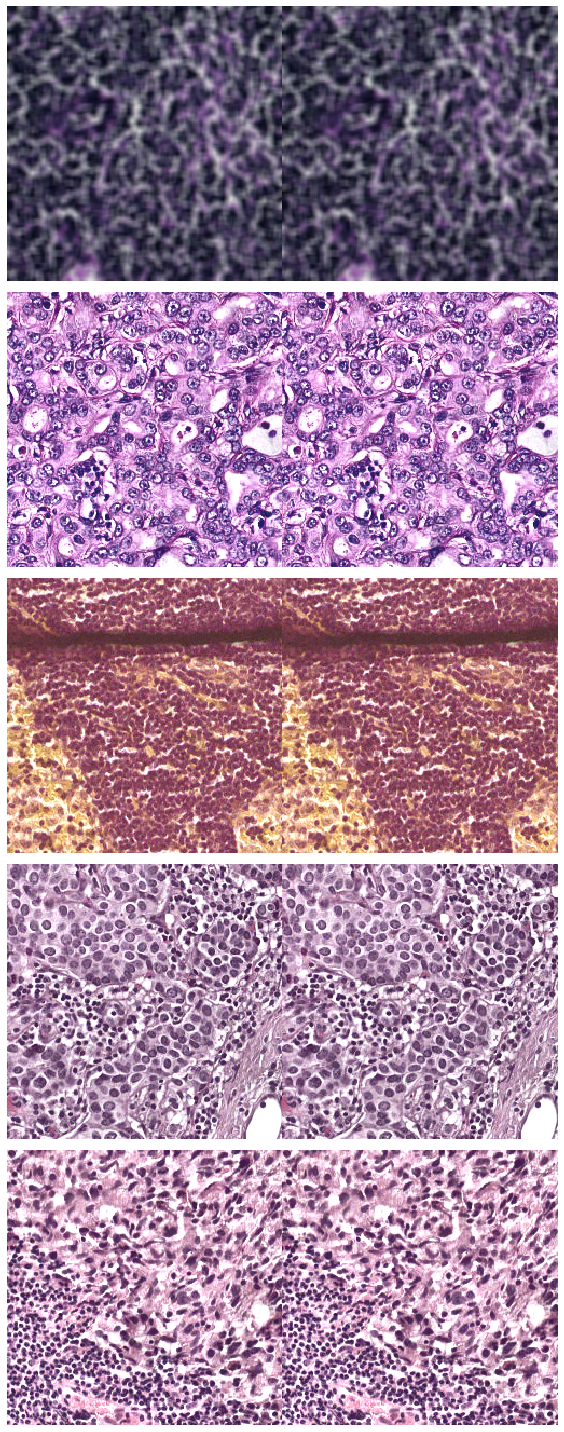

In [10]:
db.show_batch()

## Build encoder

In [11]:
encoder = se_resnext50_32x4d(pretrained=True).cuda()
encoder

Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): 

In [12]:
# drop   (5): AvgPool2d(kernel_size=7, stride=1, padding=0)
#        (6): Linear(in_features=2048, out_features=1000, bias=True)
encoder = encoder[:5]

In [13]:
t,_ = next(iter(db.dl()))

In [14]:
t.size()

torch.Size([64, 3, 256, 256])

In [15]:
# pipe through network ad check the shape
encoder(t).size()

torch.Size([64, 2048, 8, 8])

In [16]:
# the output size currently is
2048 * 8 * 8

131072

In [17]:
# image size is
256 * 256 * 3

196608

Considering that the task of the autoencoder is to map the image to a different format, and then back to the image. We want to have less parameters in the encoded format. 

In [18]:
code_sz = 64

conv = nn.Conv2d(2048, code_sz, kernel_size=(2,2)).cuda()

encoder.add_module('CodeIn',conv)

In [19]:
encoder(t).size()

torch.Size([64, 64, 7, 7])

## Decoder

In [20]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out,out_shape=None,scale=2):
        super().__init__()
        self.conv = nn.Conv2d(feat_in,feat_out,kernel_size=(3,3),stride=1,padding=1)
        self.out_shape,self.scale = out_shape,scale
        
    
    def forward(self,x):
        return self.conv(
            nn.functional.interpolate(
                x,size=self.out_shape,scale_factor=self.scale,mode='bilinear',align_corners=True))

In [21]:
def get_upSamp(feat_in,feat_out, out_shape=None, scale=2, act='relu'):
    
    upSamp = UpSample(feat_in,feat_out,out_shape=out_shape,scale=scale).cuda()
    
    layer = nn.Sequential(upSamp)
    
    if act == 'relu':
        act_f = nn.ReLU(inplace=True).cuda()
        bn = nn.BatchNorm2d(feat_out).cuda()
        layer.add_module('ReLU',act_f)
        layer.add_module('BN',bn)
    elif act == 'sig':
        act_f = nn.Sigmoid()
        layer.add_module('Sigmoid',act_f)
    return layer

def add_layer(m,feat_in,feat_out,name,out_shape=None,scale=2,act='relu'):
    upSamp = get_upSamp(feat_in,feat_out,out_shape=out_shape,scale=scale,act=act)
    m.add_module(name,upSamp)

Piece up

In [22]:
add_layer(encoder,code_sz,512,'CodeOut',out_shape=(16,16),scale=None)

In [23]:
encoder(t).size()

torch.Size([64, 512, 16, 16])

In [24]:
add_layer(encoder,512,256,'Upsample0')
encoder(t).size()

torch.Size([64, 256, 32, 32])

In [25]:
add_layer(encoder,256,128,'Upsample1')
encoder(t).size()

torch.Size([64, 128, 64, 64])

In [26]:
add_layer(encoder,128,64,'Upsample2')
encoder(t).size()

torch.Size([64, 64, 128, 128])

In [27]:
add_layer(encoder,64,3,'Upsample3',act='sig')
encoder(t).size()

torch.Size([64, 3, 256, 256])

In [28]:
encoder(t).size(), t.size()

(torch.Size([64, 3, 256, 256]), torch.Size([64, 3, 256, 256]))

In [29]:
encoder[5]

Conv2d(2048, 64, kernel_size=(2, 2), stride=(1, 1))

## Learner

In [30]:
learner = Learner(db,encoder,loss_func=F.mse_loss)
learner.split(lambda m: (m[4],m[5]))

Learner(data=ImageDataBunch;

Train: LabelList (107768 items)
x: AugmentedImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: AugmentedImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Valid: LabelList (26942 items)
x: AugmentedImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: AugmentedImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottl

In [31]:
learner.freeze_to(2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


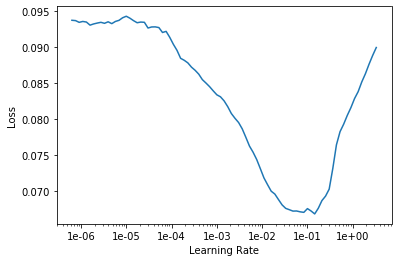

In [32]:
learner.lr_find()
learner.recorder.plot()

In [33]:
learner.fit_one_cycle(10,2e-3)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Is this learning?

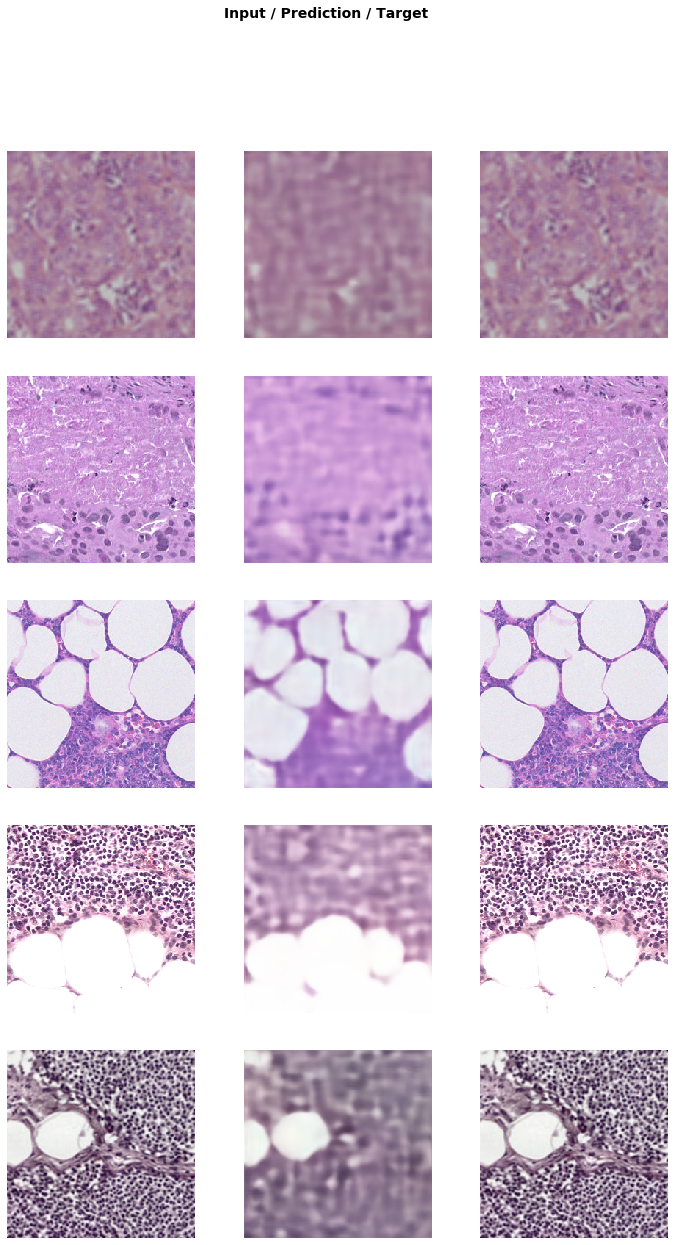

In [34]:
learner.show_results()

In [35]:
learner.save('20190827-Autoencoder_se_resnext50_aug_lvl2_midphase')

Okay, the whole point of training the autoencoder is to pretrain the weights for a multilevel model. So far, the whole encoder part has been freezed to avoid messing the weights with untrained tail. Now, we can unfreeze the last few blocks of the encoder for pretraining.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


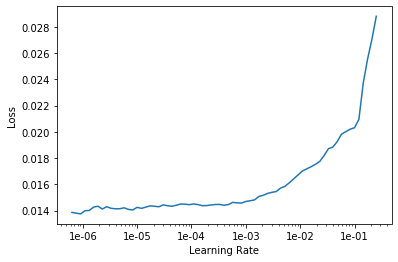

In [36]:
learner.freeze_to(1)
learner.lr_find()
learner.recorder.plot()

In [37]:
learner.fit_one_cycle(8,8e-5)

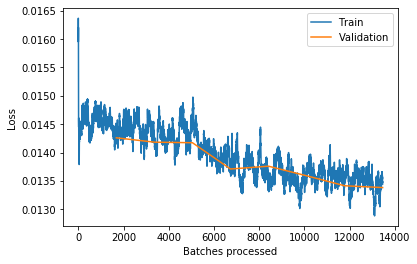

In [38]:
learner.recorder.plot_losses()

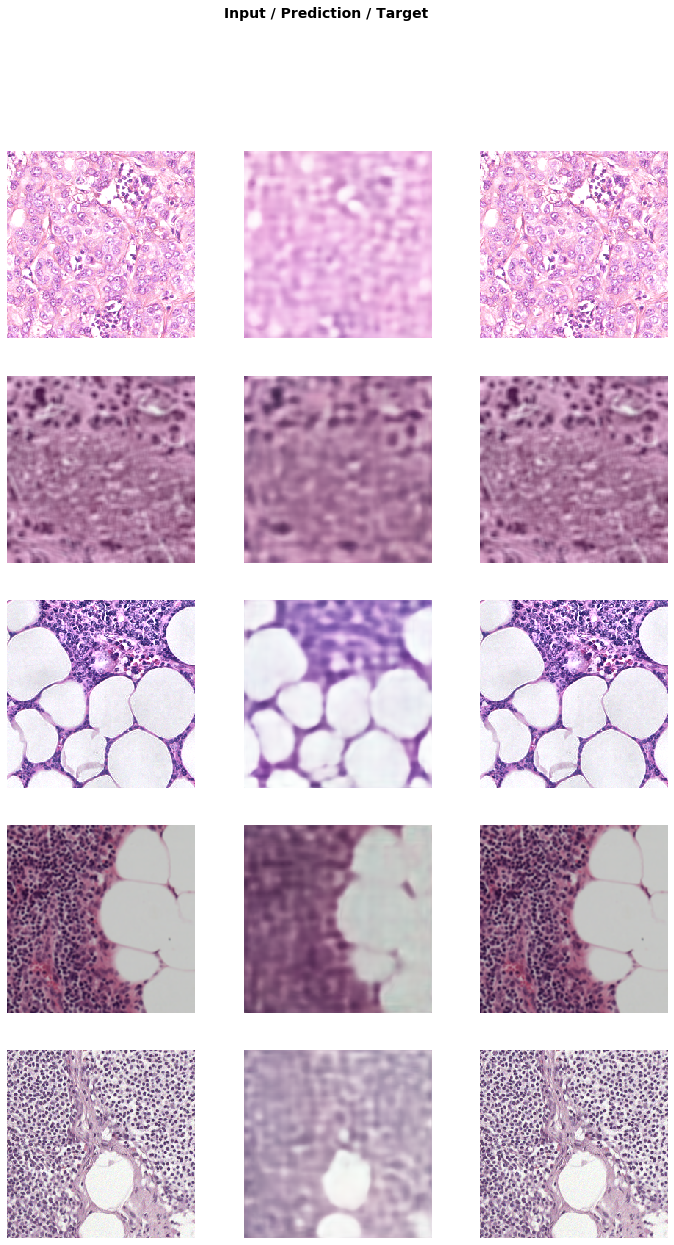

In [39]:
learner.show_results()

In [40]:
learner.save('20190827-Autoencoder_se_resnext50_aug_lvl2')

In [41]:
# final phase. unfreeze the whole model
learner.unfreeze()

In [42]:
learner.fit_one_cycle(4,1e-5)

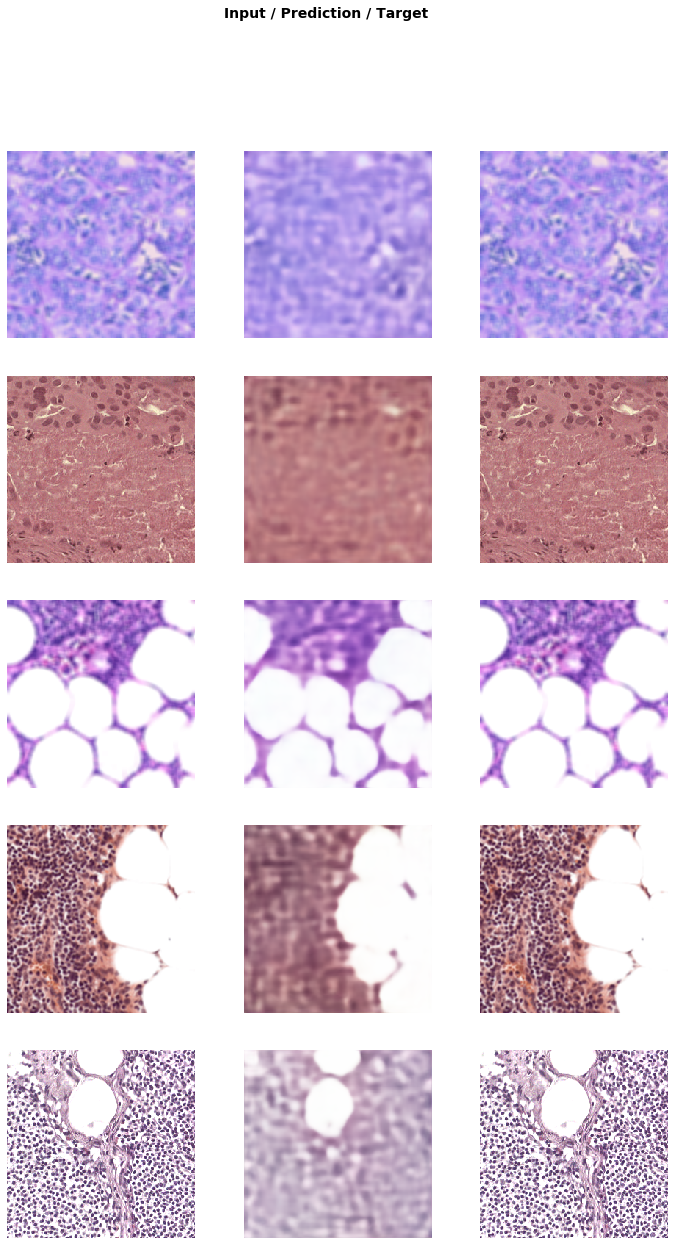

In [43]:
learner.show_results()

In [44]:
learner.save('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned')

In [45]:
learner.fit_one_cycle(8,1e-4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



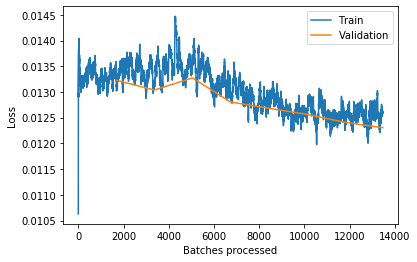

In [46]:
learner.recorder.plot_losses()

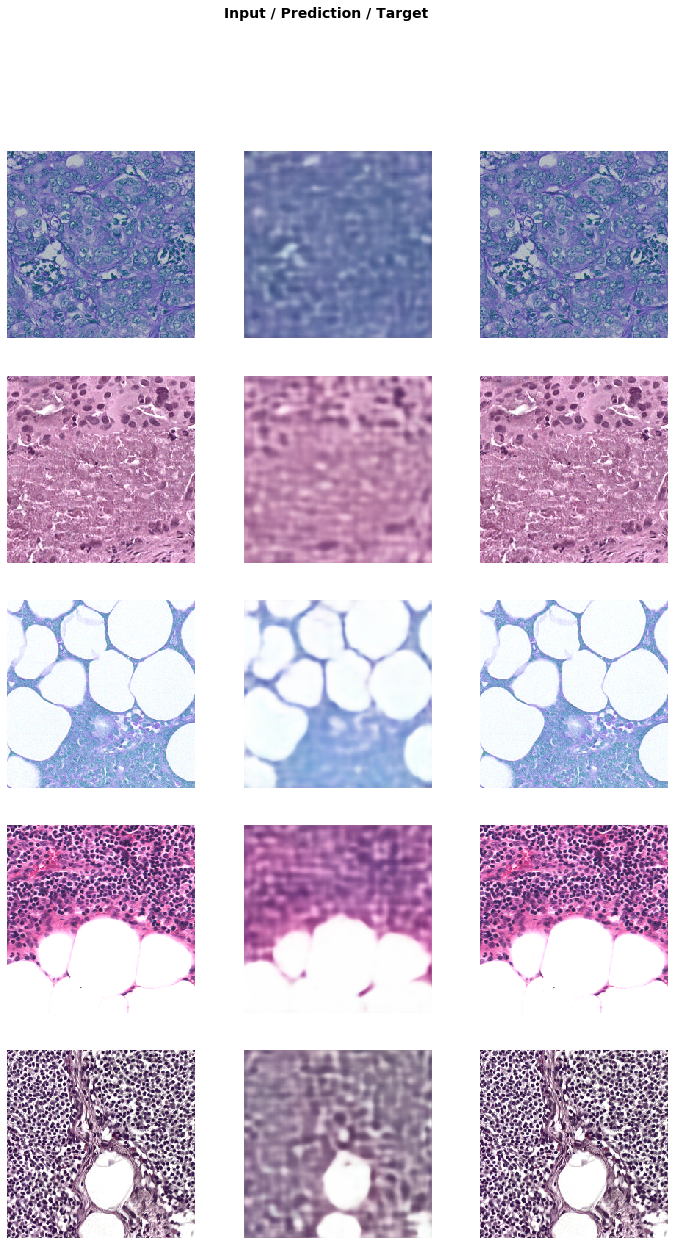

In [47]:
learner.show_results()

In [48]:
learner.save('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned2')

In [49]:
learner.fit_one_cycle(8,2e-4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



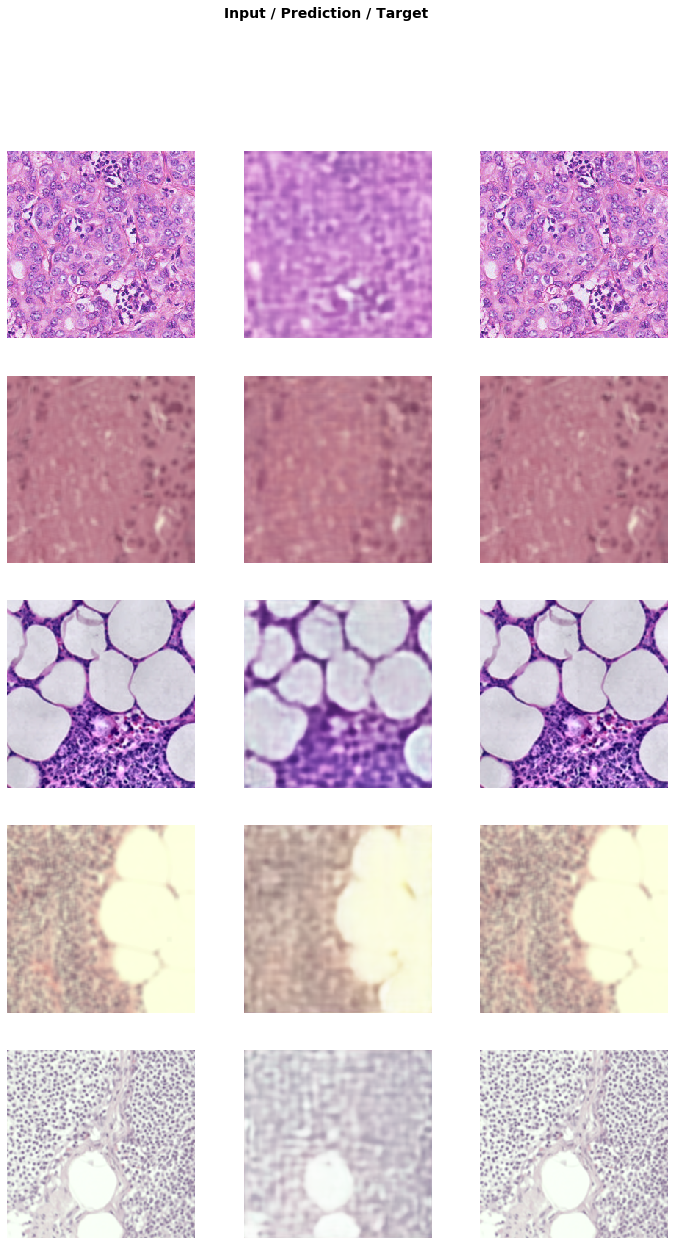

In [50]:
learner.show_results()

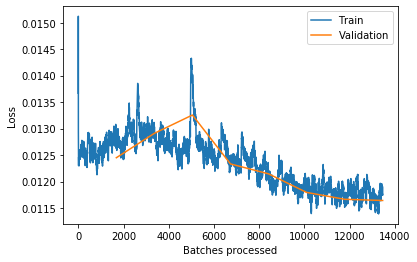

In [51]:
learner.recorder.plot_losses()

In [52]:
learner.save('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned3')

In [53]:
learner.fit_one_cycle(8,4e-4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



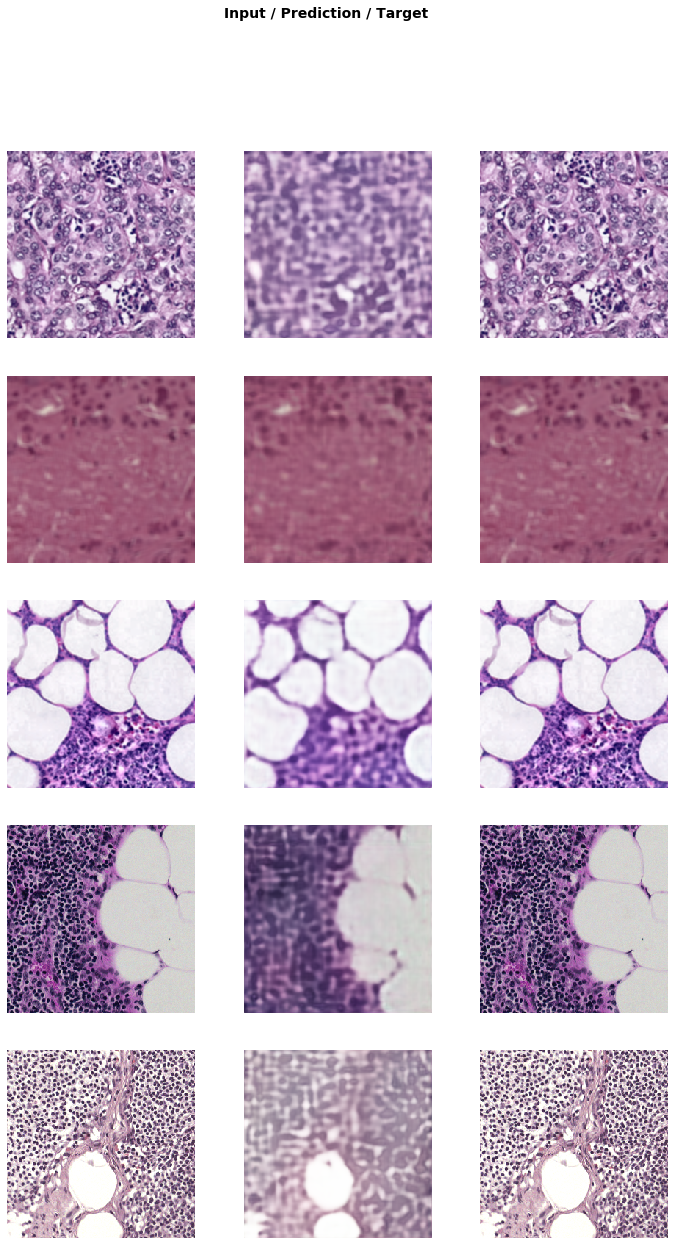

In [54]:
learner.show_results()

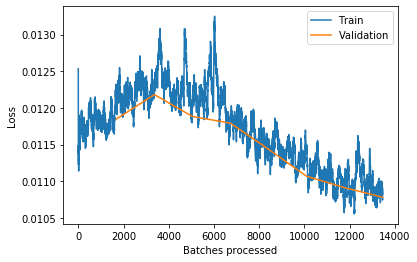

In [55]:
learner.recorder.plot_losses()

In [56]:
learner.save('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned4')

## Interpolate

In [57]:
learner.load('20190827-Autoencoder_se_resnext50_lvl2_aug_finetuned4')

/home/jonijuvonen/.conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UpSample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (107768 items)
x: AugmentedImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: AugmentedImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Valid: LabelList (26942 items)
x: AugmentedImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: AugmentedImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottl

In [58]:
learner.model

Sequential(
  (0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_pool): 

In [59]:
decoder0 = learner.model.CodeOut
decoder1 = learner.model.Upsample0
decoder2 = learner.model.Upsample1
decoder3 = learner.model.Upsample2
decoder4 = learner.model.Upsample3

In [60]:
vec = Tensor(size=(1,64,7,7)).float().cuda()
vec.size()

torch.Size([1, 64, 7, 7])

In [61]:
decoder4(decoder3(decoder2(decoder1(decoder0(vec))))).shape

torch.Size([1, 3, 256, 256])

In [62]:
def decode(vector):
    with torch.no_grad():
        im = decoder4(decoder3(decoder2(decoder1(decoder0(vector)))))
        return Image(im[0])

In [63]:
encoder0 = learner.model[:5]
encoder1 = learner.model.CodeIn

In [64]:
def encode(im):
    with torch.no_grad():
        return encoder1(encoder0(im))[0]

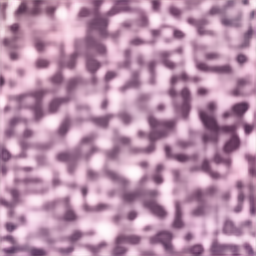

In [65]:
im_1 = encode(t[19].reshape(1,3,256,256)).reshape(1,64,7,7)
decode(im_1)

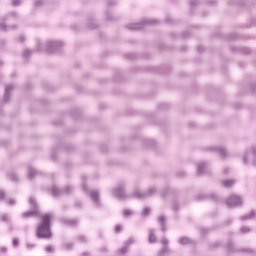

In [66]:
im_2 = encode(t[1].reshape(1,3,256,256)).reshape(1,64,7,7)
decode(im_2)

In [67]:
def interpolate(im1, im2, alpha=0.5):
    im = im1 * alpha + im2 * (1-alpha)
    return decode(im)

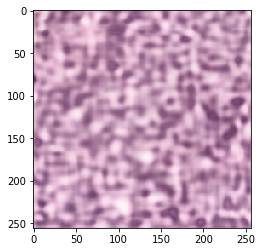

In [68]:
plt.imshow(image2np(interpolate(im_1,im_2,alpha=0.75).data))

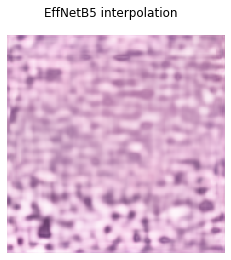

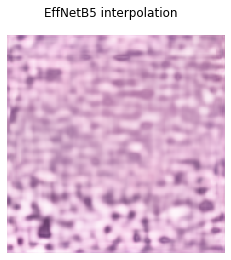

In [69]:
from IPython import display
import time
%matplotlib inline

alpha_int = 0
while(alpha_int < 21):    
        
    plt.clf()
    img = image2np(interpolate(im_2,im_1,alpha=alpha_int/20).data)
    plt.imshow(img)
    plt.suptitle('EffNetB5 interpolation')
    plt.axis('off')
    plt.savefig('img/EffNetB5_interpolation_' + str(alpha_int + 20)+'.png')
    #frame update
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.)
        
    alpha_int += 1

In [70]:
#learner.predict(Image(torch.clamp((t[1]*0.22 + 0.45),0,1).cpu()))[0]

In [71]:
#[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [72]:
#torch.clamp((t[1]*0.22 + 0.45),0,1).max()

In [73]:
#learner.show_results()